In [35]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [36]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [37]:
url_list[:5]

['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451723',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451721',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451718',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009849190',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451717']

In [38]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [39]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [40]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


In [41]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [42]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [43]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [44]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  60


In [45]:
df.sample(10)

,news,code
4,지난 2016년 포항공대에 구축한 4세대 선형 방사광가속기. /연합뉴스 지난 201...,IT/과학
6,[서울=뉴시스] 오동현 기자 = 펍지주식회사가 올해 첫 '플레이어언노운스 배틀그라운...,IT/과학
7,동영상 뉴스\n\n5월 날씨가 맞나 싶으시죠.오늘도 초여름이었습니다.심지어 올 들어...,생활/문화
7,[한국경제TV 김주리 기자]\n\n지구에서 약 1천광년밖에 떨어지지 않은 곳에서 맨...,IT/과학
2,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,IT/과학
17,바티칸의 사도궁 집무실에서 6일(현지시간) 인터넷 중계 방식의 수요 일반 알현 훈화...,생활/문화
5,사진=에듀윌 사진=에듀윌\n\n계리직공무원은 우체국 내에서 현장 창구 업무를 비롯해...,생활/문화
7,1977년 메이저리그 LA 다저스의 시즌 마지막 경기였다. 신인 타자 더스티 베이커...,사회
13,38명의 사망자가 발생한 경기 이천 물류창고 화재 현장에서 6일 경찰과 소방 등 관...,사회
10,안병용 의정부시장 이천화재 희생자 합동분향소 헌화. 사진제공=의정부시 안병용 의정부...,사회


In [46]:
csv_path = "news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [47]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

In [48]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [49]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


In [50]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


<AxesSubplot:>

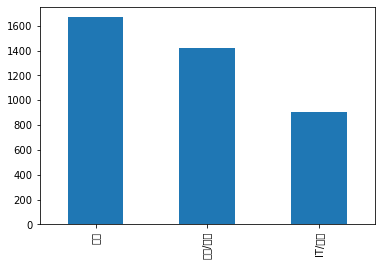

In [51]:
df['code'].value_counts().plot(kind = 'bar')

In [70]:
df['code'].value_counts()

사회       1668
생활/문화    1423
IT/과학     903
Name: code, dtype: int64

In [52]:
print(df.groupby('code').size().reset_index(name = 'count'))

code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


In [53]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [54]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [55]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data,mode):
  text_data = []
  mode = mode.lower()
  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [56]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [58]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [59]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [60]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [61]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [62]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [63]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [64]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [65]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



# Step 1. 형태소 분석기 변경해 보기

한국어 자연어 처리에 성능에 영향을 주는 또 다른 요소는 사용하는 형태소 분석기의 종류입니다. 앞서 진행한 프로젝트에서는 Mecab을 사용했었습니다. 하지만 이번에 설치한 konlpy 패키지 안에는 Mecab 이외에도 Hannanum, Kkma, Komoran, Okt 라는 형태소분석기가 존재합니다. 이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.

In [73]:
from konlpy.tag import Mecab, Komoran,Kkma,Hannanum

In [74]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data,mode):
  text_data = []
  mode = mode.lower()

  if mode == "mecab":
      tokenizer = Mecab()
  elif mode == 'komoran':
      tokenizer = Komoran()
  elif mode == 'kkma':
      tokenizer = Kkma()
  elif mode == 'hannanum':
      tokenizer = Hannanum()        

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [75]:
text_data1 = preprocessing(df['news'],"mecab")
text_data2 = preprocessing(df['news'],"komoran")
text_data3 = preprocessing(df['news'],"kkma")
text_data4 = preprocessing(df['news'],"hannanum")

In [76]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [77]:
X_train, X_test, y_train, y_test = train_test_split(text_data1, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



In [78]:
X_train, X_test, y_train, y_test = train_test_split(text_data2, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.80      0.91      0.85       422
       생활/문화       0.81      0.77      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



In [79]:
X_train, X_test, y_train, y_test = train_test_split(text_data3, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.75      0.82       236
          사회       0.80      0.91      0.85       422
       생활/문화       0.81      0.77      0.79       341

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



In [80]:
X_train, X_test, y_train, y_test = train_test_split(text_data4, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.64      0.75       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.79      0.79      0.79       341

    accuracy                           0.81       999
   macro avg       0.83      0.78      0.80       999
weighted avg       0.82      0.81      0.81       999

